In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
%%writefile content2.json

{"intents":
 [
    {
        "tag":"greeting",
        "input": ["hello", "Hi there", "hey there", "hey", "nice to meet you"],
        "responses":[
          "Hi, do you need any help ?",
          "Welcome aboard, how may I help you ?",
          "Hello my friend, how can I help you ?",
          "Hey, what can I do for you ?",
          "Hey, how are you ?"
        ]
    },
    {
        "tag":"goodbye",
        "input": ["thankyou", "thanks", "bye", "goodbye", "see you later", "talk to you later", "thanks for the info", "okay bye", "okay"],
        "responses":[
          "Okay, bye",
          "Have a nice day",
          "Goodbye",
          "Adios",
          "See you later",
          "It was a nice conversation, bye",
          "Take care",
          "Yeah sure, will talk to you later"
        ]
    },
    {
        "tag":"whereareyou",
        "input": ["where are you from ?", "which country are you from ?", "where do you live ?", "where are you ?", "which place do you come from ?"],
        "responses":[
          "I come from Pluto",
          "Pluto, do you know the planet ?",
          "pluto, that's where I live",
          "I came from Pluto to help the humans on the Earth"
        ]
    },
    {
        "tag":"courtesygreeting",
        "input": ["how are you ?", "how are you doing ?", "hello, how are you ?", "hope you are doing well", "Hey, are you doing well ?"],
        "responses":[
          "Hello, I am great, how are you?",
          "Hello, how are you? I am great thanks!",
          "Hello, I am good thank you, how are you?",
          "Hi, I am good thank you, how are you?",
          "Hi, I am great, how are you ?",
          "Hi, I am doing great, hope you are doing great too"
        ]
    },
    {
        "tag":"courtesygreetingresponse",
        "input": ["great, thanks", "good thanks", "good", "great thanks"],
        "responses":[
            "Great! Hi ! How can I help?",
            "Good! Hi, how can I help you?",
            "Cool! Hello, what can I do for you?",
            "OK! Hola, how can I help you?",
            "OK! hi, what can I do for you?"
        ]
    },
    {
        "tag": "Thanks",
        "input": [
            "OK thank you",
            "OK thanks",
            "OK",
            "Thanks",
            "Thank you",
            "That's helpful"
         ],
        "responses": [
            "No problem!",
            "Happy to help!",
            "Any time!",
            "My pleasure"
        ]
    },
    {
      "tag":"howami",
     "input":["how are you?", "I am fine, how are you?", "are you fine?", "how are things going on?", "everything going on okay?", "how's everything going on?", "how are you doing?"],
     "responses":[
         "Yeah am fine",
         "Everything's going on well",
         "Doing good. Thanks you are my bestfriend",
         "Things are great",
         "Yeah fine, nothing much going on in my life",
         "I am great. Wanna join the pluto's organization?",
         "Everything's great",
         "I am doing good. Life is boring. Need to go on an adventure"
     ]
    },
    {
        "tag":"whoareyou",
     "input": ["who are you?", "what are you?", "what is your name?", "are you a chatbot?", "what can I call you?", "your name?", "are you a bot?"],
     "responses": [
         "I am Pluto, a cute chatbot.",
         "I am Pluto, a chatbot",
         "My name is Pluto",
         "Yes. Pluto at your service",
         "You can call me TechBot and I am here to help you",
         "My name is Pluto and I am here to answer your questions"
     ]
    }
 ]
}

Overwriting content2.json


In [ ]:
#importing the dataset

with open('content2.json') as content:
  data1 = json.load(content)

In [ ]:
#getting data into lists

tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
data = pd.DataFrame({"inputs":inputs, "tags":tags})

In [ ]:
data

,inputs,tags
0,hello,greeting
1,Hi there,greeting
2,hey there,greeting
3,hey,greeting
4,nice to meet you,greeting
5,thankyou,goodbye
6,thanks,goodbye
7,bye,goodbye
8,goodbye,goodbye
9,see you later,goodbye


Preprocessing

In [ ]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,hey there,greeting
3,hey,greeting
4,nice to meet you,greeting
5,thankyou,goodbye
6,thanks,goodbye
7,bye,goodbye
8,goodbye,goodbye
9,see you later,goodbye


In [ ]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
# from sklearn.preprocessing import LabelEncoder 
# le = LabelEncoder()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# y_train = le.fit(data['tags'])
y_train = le.fit_transform(data['tags'])

In [ ]:
input_shape = x_train.shape[1]
print(input_shape)

6


In [ ]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length : ", output_length)

number of unique words :  56
output length :  8


In [ ]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model = Model(i,x)

In [ ]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=['accuracy'])


In [ ]:
 #training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
2/2 [==============================] - 2s 13ms/step - loss: 2.0791 - accuracy: 0.2083
Epoch 2/200
2/2 [==============================] - 0s 10ms/step - loss: 2.0773 - accuracy: 0.2083
Epoch 3/200
2/2 [==============================] - 0s 10ms/step - loss: 2.0753 - accuracy: 0.2708
Epoch 4/200
2/2 [==============================] - 0s 10ms/step - loss: 2.0737 - accuracy: 0.3125
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 2.0718 - accuracy: 0.3125
Epoch 6/200
2/2 [==============================] - 0s 9ms/step - loss: 2.0702 - accuracy: 0.3333
Epoch 7/200
2/2 [==============================] - 0s 9ms/step - loss: 2.0683 - accuracy: 0.3125
Epoch 8/200
2/2 [==============================] - 0s 13ms/step - loss: 2.0666 - accuracy: 0.3125
Epoch 9/200
2/2 [==============================] - 0s 9ms/step - loss: 2.0648 - accuracy: 0.3125
Epoch 10/200
2/2 [==============================] - 0s 12ms/step - loss: 2.0628 - accuracy: 0.3125
Epoch 11/200
2/2 [=====

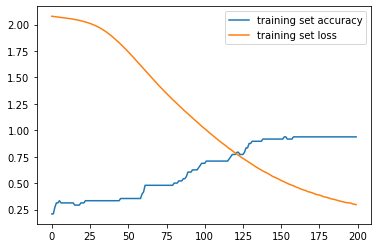

In [ ]:
#model analysis

#plotting model accuracy
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

Testing

In [ ]:
#chatting
import random

while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and moving  to lower case
  prediction_input =[letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from the model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Pluto : ", random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You : hey
Pluto :  Hey, what can I do for you ?
You : who are you
Pluto :  You can call me TechBot and I am here to help you
You : where are you from
Pluto :  pluto, that's where I live
You : thats great
Pluto :  No problem!
You : what do you do
Pluto :  Yes. Pluto at your service
You : how are do doing?
Pluto :  Yeah fine, nothing much going on in my life
You : thanks for the info
Pluto :  Yeah sure, will talk to you later
